In [104]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.accelerated_shift_net.accelerated_InnerShiftTriple import AcceleratedInnerShiftTriple
from options.train_options import TrainOptions 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CREATE DEFAULT OPTIONS TO INITIALIZE THE SHIFTMODEL

In [105]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class4_def/' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
options = '--dataroot {}'.format(dataroot).split(' ')

In [106]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [107]:
parser = get_parser(options=options)

----------------- Options ---------------
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: /mnt/hdd2/AIM/checks          
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class4_def/	[default: /mnt/hdd2/AIM/DAGM/Class4]
             dataset_mode: aligned_resized               
             display_freq: 10                            
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
display_single_pane_ncols: 0                             
          display_winsize: 256                           
              epoch_count: 1                       

# CREATE INNER_SHIFT_TRIPLE LAYER

In [108]:
#from models.InnerShiftTriple import InnerShiftTriple

In [109]:
opt = parser.opt
#opt

In [110]:
inner_shift_triple = AcceleratedInnerShiftTriple(opt.threshold, opt.fixed_mask)

In [111]:
inner_shift_triple.cuda()

AcceleratedInnerShiftTriple(threshold: 0.3125 ,triple_weight 1)

# EVALUE SPEED FORWARD

### THE SIZE OF THE INPUT TENSOR IS (BATCH_SIZE, 256 * 2 (former | latter), 32, 32). LET CREATE A RANDOM TENSORS AND EVALUTE ITS FORWARD FIRST

In [112]:
import numpy as np
torch.cuda.is_available()

True

### NOW WE NEED TO SET UP THE MASK

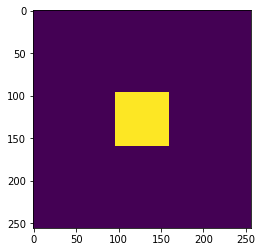

In [113]:
c, h, w = (1, 256, 256)
hh = h//2
wh = w//2
hm_size = 32
mask = np.zeros((1, c, h, w))
mask[..., hh - hm_size:hh + hm_size, wh - hm_size:wh + hm_size] = 1
#mask[..., h - hh:, :] = 1
mask_global=torch.ByteTensor(mask).cuda()#.cpu()
plt.imshow(np.squeeze(mask))

In [114]:
inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:1', dtype=torch.uint8)

In [162]:
x_np = np.random.normal(0, 1, (1, 512, 32, 32))
x_tr = torch.FloatTensor(x_np)

In [168]:
%timeit output = inner_shift_triple(x_tr.cuda())
#output = inner_shift_triple(x_tr.cuda())
#flag, indexes, ind_lst = inner_shift_triple(x_tr.cuda())

[autoreload of models.accelerated_shift_net.accelerated_InnerShiftTripleFunction failed: Traceback (most recent call last):
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3

128 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
ind_lst[tuple((flag, indexes))] = 1

[autoreload of models.accelerated_shift_net.accelerated_InnerShiftTripleFunction failed: Traceback (most recent call last):
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/home/tchaton/virtualenvs/labelbox/lib/python3

NameError: name 'ind_lst' is not defined

In [51]:
torch.sum(ind_lst)

tensor(64)

In [593]:
x = torch.FloatTensor(np.array(range(1024)))

In [594]:
transition_matrx = torch.zeros((1024, 1024))

In [600]:
f1 = (flag == 0).nonzero()[indexes]

tensor([[429],
        [215],
        [172],
        [163],
        [400],
        [448],
        [491],
        [ 91],
        [111],
        [240],
        [385],
        [ 49],
        [122],
        [211],
        [164],
        [223],
        [104],
        [368],
        [253],
        [ 34],
        [443],
        [160],
        [389],
        [390],
        [486],
        [354],
        [  7],
        [379],
        [123],
        [371],
        [449],
        [258],
        [168],
        [217],
        [368],
        [285],
        [ 25],
        [179],
        [240],
        [139],
        [209],
        [224],
        [198],
        [239],
        [490],
        [ 61],
        [289],
        [260],
        [478],
        [497],
        [385],
        [359],
        [309],
        [110],
        [227],
        [235],
        [ 70],
        [352],
        [ 12],
        [434],
        [470],
        [145],
        [297],
        [501],
        [444],
        [388],
        [4

In [584]:
flag_n = flag

In [585]:
idx = tuple((np.where(flag_n == 1), f1))

In [586]:
transition_matrx[idx] = 1

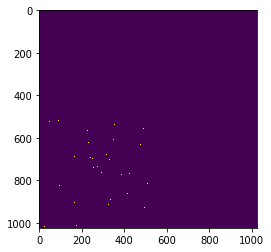

In [587]:
plt.imshow(transition_matrx)

In [413]:
tmp = tmp[:, cp]
tmp.shape

(64, 1024, 960)

In [412]:
cp = np.where(flag == 0)[0][indexes][0] == flag

In [405]:
indexes

tensor([732, 881, 809, 813, 333, 865,  60, 265, 848, 653, 611, 284,  88, 956,
        773, 598, 437, 740, 308, 536, 517, 241, 898, 428, 257, 494, 287, 898,
        618, 628, 779, 389, 122, 211, 164, 223, 104, 732, 253,  34, 843, 543,
        289, 260, 454, 918, 385, 359, 919, 126, 203, 522,   6, 372, 490, 841,
        723,  72, 651, 242, 710,  73, 608, 140], device='cuda:3')

In [391]:
tmp[:, 0, indexes] = 1

In [396]:
np.sum(tmp)

3968.0

In [397]:
np.sum(transition_matrx)

0.0

In [ ]:
torch.sum(flag)

In [357]:
indexes

tensor([501, 176, 230, 954, 370, 828, 848, 937, 346, 140, 227, 259, 303,  63,
        813, 783, 163, 681, 181, 497, 242, 667, 758, 431, 888, 361, 725, 785,
        103, 913, 251, 461, 368, 116, 930, 251,  56, 413, 598, 464, 250, 114,
         10, 938, 709, 224, 634,  51, 910, 323, 248,  72, 290, 575,  14, 239,
        817, 494, 530, 723, 475, 217, 599, 147], device='cuda:3')

In [316]:
output.shape

torch.Size([1, 768, 32, 32])

In [ ]:
from util import util
import torch.nn.functional as F

In [ ]:
def create_random_mask(opt):
    gMask_opts = {}
    mask_global = torch.ByteTensor(1, 1, \
                                 opt.fineSize, opt.fineSize)

        # Here we need to set an artificial mask_global(not to make it broken, so center hole is ok.)
    mask_global.zero_()
    mask_global[:, :, int(opt.fineSize/4) + opt.overlap : int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap,\
                                int(opt.fineSize/4) + opt.overlap: int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap] = 1  
    
    res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
    density = 0.25
    MAX_SIZE = 300
    maxPartition = 30
    low_pattern = torch.rand(1, 1, int(res*MAX_SIZE), int(res*MAX_SIZE)).mul(255)
    pattern = F.upsample(low_pattern, (MAX_SIZE, MAX_SIZE), mode='bilinear').data
    low_pattern = None
    pattern.div_(255)
    pattern = torch.lt(pattern,density).byte()  # 25% 1s and 75% 0s
    pattern = torch.squeeze(pattern).byte()
    gMask_opts['pattern'] = pattern
    gMask_opts['MAX_SIZE'] = MAX_SIZE
    gMask_opts['fineSize'] = opt.fineSize
    gMask_opts['maxPartition'] = maxPartition
    gMask_opts['mask_global'] = mask_global
    mask_global = util.create_gMask(gMask_opts) # create an initial random mask.   
    return mask_global

In [ ]:
%time mask_global = create_random_mask(opt)

In [ ]:
mask_global.shape

In [ ]:
plt.imshow(np.squeeze(mask_global))

In [ ]:
mask_global

In [ ]:
inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

In [ ]:
%timeit output = inner_shift_triple.forward(x_tr.cuda())

# THE ENTIRE PROCESS IS PRETTY FAST, THE ISSUE WAS COMING FROM THE MASK GENERATOR

# IMPLEMENT AN ACCELERATE MODULE

In [ ]:
opt = parser.opt
opt.shift_sz = 1

In [ ]:
from models.accelerated_InnerShiftTriple import AcceleratedInnerShiftTriple
acce_inner_shift_triple = AcceleratedInnerShiftTriple(opt.threshold, opt.fixed_mask)

In [ ]:
acce_inner_shift_triple.cuda()

In [ ]:
acce_inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

In [ ]:
%timeit output = acce_inner_shift_triple(x_tr.cuda())

In [ ]:
acce_inner_shift_triple.__dict__

In [170]:
print('THE SPEED UP IS {} FOLD'.format(582/115))

THE SPEED UP IS 5.060869565217391 FOLD
